# Sampling Methods

## Old EM 1D code

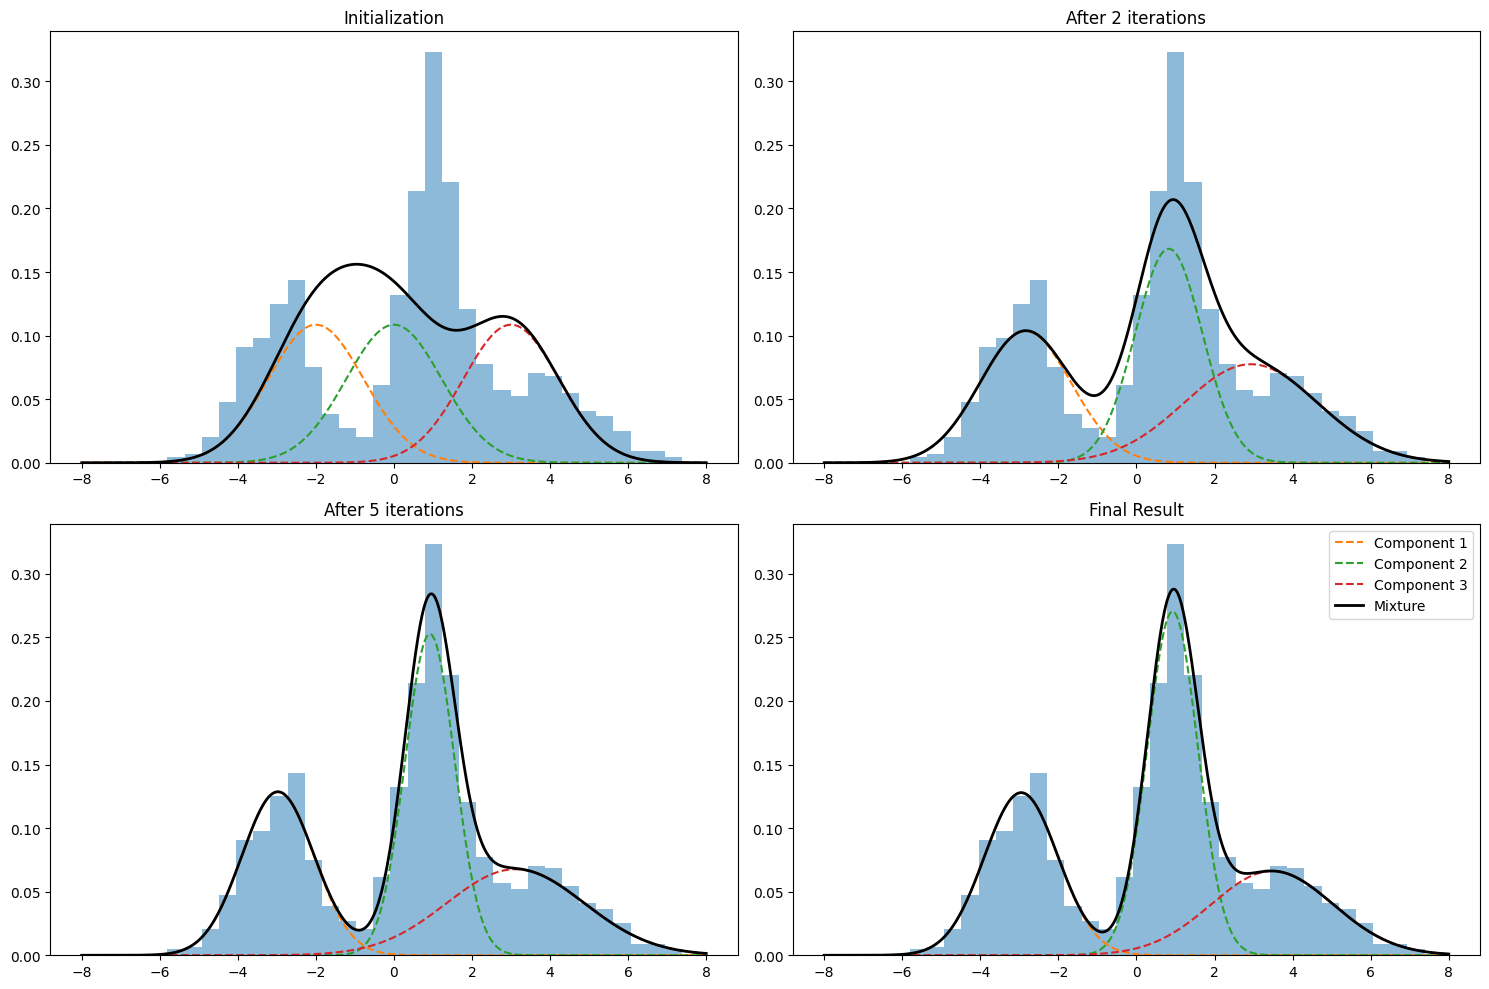

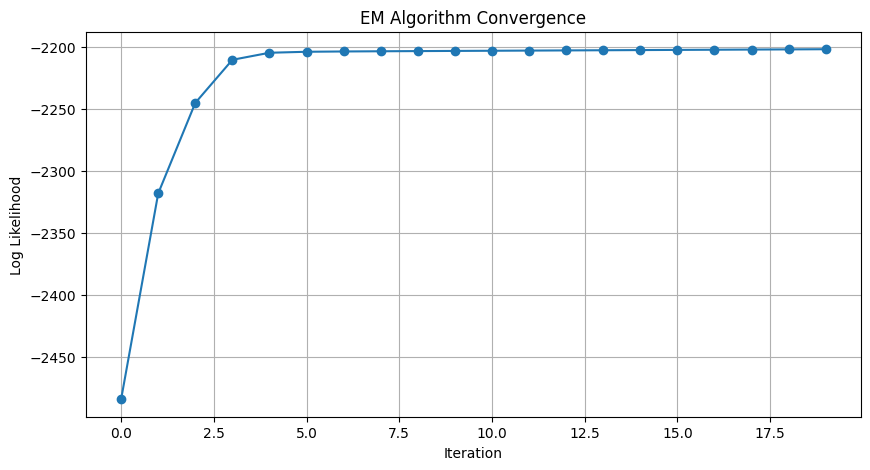

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set random seed for reproducibility
np.random.seed(0)

# Parameters
K = 3  # Number of Gaussian components
N = 1000  # Number of data points
max_iter = 20  # Maximum EM iterations

# True parameters for data generation
true_means = np.array([-3, 1, 4])
true_covariances = np.array([1, 0.5, 1.5])  # variances in 1D
true_pi = np.array([0.3, 0.5, 0.2])  # mixing coefficients

# Generate synthetic data
components = np.random.choice(K, size=N, p=true_pi)
data = np.array([np.random.normal(true_means[k], np.sqrt(true_covariances[k])) for k in components])

# Initialize parameters (purposely different from true values)
means = np.array([-2, 0, 3])  # means μ_k
covariances = np.array([1.5, 1.5, 1.5])  # σ_k^2
pi = np.ones(K)/K  # uniform initial weights

# Store history for visualization
history = {'means': [means.copy()], 
           'covariances': [covariances.copy()], 
           'pi': [pi.copy()],
           'log_likelihood': []}

# EM Algorithm
for iteration in range(max_iter):
    # E-step: Compute responsibilities γ(z_nk) - Equation 1
    gamma = np.zeros((N, K))
    for k in range(K):
        gamma[:, k] = pi[k] * norm.pdf(data, means[k], np.sqrt(covariances[k]))
    gamma /= gamma.sum(axis=1, keepdims=True)  # normalize
    
    # M-step: Update parameters - Equations 2-5
    Nk = gamma.sum(axis=0)  # Equation 5
    
    # Update means - Equation 2
    new_means = np.array([np.sum(gamma[:, k] * data) / Nk[k] for k in range(K)])
    
    # Update covariances - Equation 3 (simplified for 1D)
    new_covariances = np.array([np.sum(gamma[:, k] * (data - new_means[k])**2) / Nk[k] for k in range(K)])
    
    # Update mixing coefficients - Equation 4
    new_pi = Nk / N
    
    # Compute log likelihood - Equation 6
    log_likelihood = np.sum([np.log(np.sum([pi[k] * norm.pdf(x, means[k], np.sqrt(covariances[k])) 
                                          for k in range(K)])) for x in data])
    
    # Store current parameters
    history['means'].append(new_means.copy())
    history['covariances'].append(new_covariances.copy())
    history['pi'].append(new_pi.copy())
    history['log_likelihood'].append(log_likelihood)
    
    # Update parameters for next iteration
    means, covariances, pi = new_means, new_covariances, new_pi

# Visualization
plt.figure(figsize=(15, 10))

# Plot initialization
plt.subplot(2, 2, 1)
x_grid = np.linspace(-8, 8, 1000)
init_means = history['means'][0]
init_covs = history['covariances'][0]
init_pi = history['pi'][0]

plt.hist(data, bins=30, density=True, alpha=0.5)
pdf = np.zeros_like(x_grid)
for k in range(K):
    component = init_pi[k] * norm.pdf(x_grid, init_means[k], np.sqrt(init_covs[k]))
    plt.plot(x_grid, component, '--')
    pdf += component
plt.plot(x_grid, pdf, 'k-', linewidth=2)
plt.title('Initialization')

# Plot after 2 iterations
plt.subplot(2, 2, 2)
iter2_means = history['means'][2]
iter2_covs = history['covariances'][2]
iter2_pi = history['pi'][2]

plt.hist(data, bins=30, density=True, alpha=0.5)
pdf = np.zeros_like(x_grid)
for k in range(K):
    component = iter2_pi[k] * norm.pdf(x_grid, iter2_means[k], np.sqrt(iter2_covs[k]))
    plt.plot(x_grid, component, '--')
    pdf += component
plt.plot(x_grid, pdf, 'k-', linewidth=2)
plt.title('After 2 iterations')

# Plot after 5 iterations
plt.subplot(2, 2, 3)
iter5_means = history['means'][5]
iter5_covs = history['covariances'][5]
iter5_pi = history['pi'][5]

plt.hist(data, bins=30, density=True, alpha=0.5)
pdf = np.zeros_like(x_grid)
for k in range(K):
    component = iter5_pi[k] * norm.pdf(x_grid, iter5_means[k], np.sqrt(iter5_covs[k]))
    plt.plot(x_grid, component, '--')
    pdf += component
plt.plot(x_grid, pdf, 'k-', linewidth=2)
plt.title('After 5 iterations')

# Plot final result
plt.subplot(2, 2, 4)
final_means = history['means'][-1]
final_covs = history['covariances'][-1]
final_pi = history['pi'][-1]

plt.hist(data, bins=30, density=True, alpha=0.5)
pdf = np.zeros_like(x_grid)
for k in range(K):
    component = final_pi[k] * norm.pdf(x_grid, final_means[k], np.sqrt(final_covs[k]))
    plt.plot(x_grid, component, '--', label=f'Component {k+1}')
    pdf += component
plt.plot(x_grid, pdf, 'k-', linewidth=2, label='Mixture')
plt.title('Final Result')
#sorry keene idk why the legend only shows in the bottom left histogram. idk how to fix it
plt.legend()

plt.tight_layout()
plt.show()

# Plot log likelihood
plt.figure(figsize=(10, 5))
plt.plot(history['log_likelihood'], 'o-')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.title('EM Algorithm Convergence')
plt.grid(True)
plt.show()

## Rejection Sampling GMM

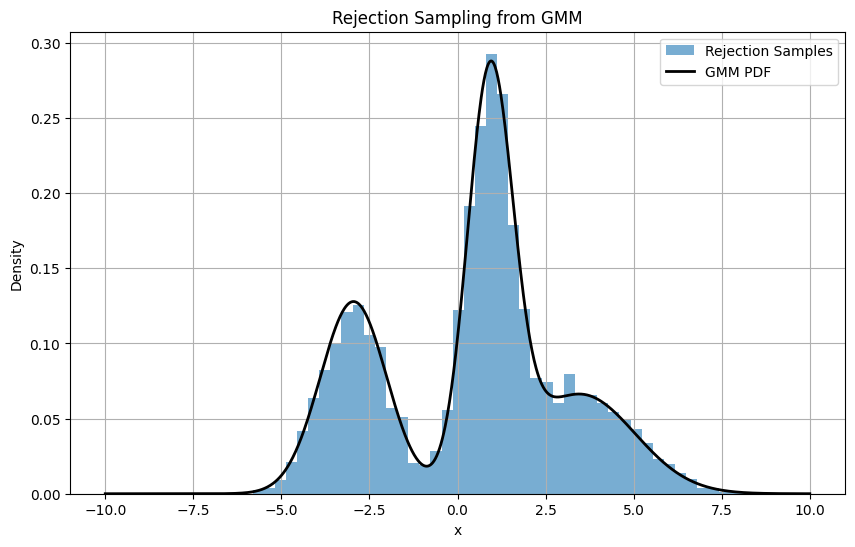

In [3]:
gmm_means = final_means
gmm_stds = np.sqrt(final_covs)
gmm_weights = final_pi

# Define target GMM density function
def gmm_pdf(x):
    return sum(w * norm.pdf(x, mu, std) for w, mu, std in zip(gmm_weights, gmm_means, gmm_stds))

# Define proposal distribution (standard normal, or wider for more coverage)
proposal_mean = 0
proposal_std = 4  # Make it wide enough to cover the GMM support
proposal_pdf = lambda x: norm.pdf(x, proposal_mean, proposal_std)
proposal_sampler = lambda size: np.random.normal(proposal_mean, proposal_std, size)

# Estimate M: the max of target(x) / proposal(x)
x_vals = np.linspace(-10, 10, 1000)
ratios = [gmm_pdf(x) / proposal_pdf(x) for x in x_vals]
M = max(ratios) * 1.1  # add buffer to ensure envelope

# Rejection sampling
num_samples = 10000
samples = []
while len(samples) < num_samples:
    x = proposal_sampler(1)[0]
    u = np.random.uniform(0, M * proposal_pdf(x))
    if u <= gmm_pdf(x):
        samples.append(x)

samples = np.array(samples)

# Plot the histogram of samples with GMM overlay
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, label='Rejection Samples')
x_grid = np.linspace(-10, 10, 1000)
pdf = np.array([gmm_pdf(x) for x in x_grid])
plt.plot(x_grid, pdf, 'k-', lw=2, label='GMM PDF')
plt.title("Rejection Sampling from GMM")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()
